In [1]:
from torch.utils.data import DataLoader # Gives easier dataset managment and creates mini batches
import torchvision.datasets as datasets # Has standard datasets we can import in a nice and easy way
import torchvision.transforms as transforms # Transformations we can perform on our dataset
import matplotlib.pyplot as plt

In [2]:
batch_size = 9

# Training data
train_dataset = datasets.MNIST(root="dataset/", train=True, transform=transforms.ToTensor(), download=True)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True) # Loads a new shuffled and batched version of the dataset

# Test data
test_dataset = datasets.MNIST(root="dataset/", train=False, transform=transforms.ToTensor(), download=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

Size per Batch: torch.Size([9, 1, 28, 28])


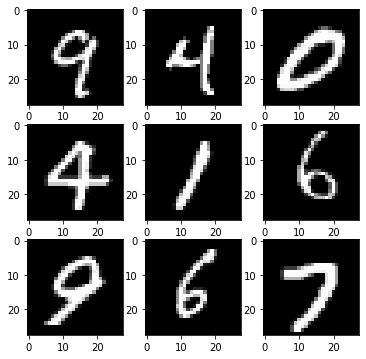

torch.Size([9, 784])


In [3]:
# The first batch always changes since before calling gets shuffleds
for i, (img, label) in enumerate(train_loader):
    if i==0:
        print(f"Size per Batch: {img.shape}")
        plt.figure(figsize=(6,6))
        for j in range(batch_size):
            plt.subplot(3,3, j+1)
            plt.imshow(img[j,0,:,:], cmap="gray")
        plt.show()
        # Reshape as first dim (so batch size) and rest gets flattened    
        print(img.reshape(img.shape[0], -1).shape)

#### How is the loss connected to the optimizer?

Why can we say optimizer.step() without plugging in the loss? Short answer: The gradient is saved in each of the parameters of the model. Calling loss.backward() just propagates the loss according to the already saved formula for the gradient (which is set to zero before). Then the optimizer just takes one step per weight according to the gradient and the other parameters. 

More info [here](https://stackoverflow.com/questions/53975717/pytorch-connection-between-loss-backward-and-optimizer-step).

In [4]:
# Check which set
test_loader.dataset.train

False

#### Setup BRATS-dataloader with channels

In [5]:
import os
import torch
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

In [6]:
os.listdir("../BRATS")

['brats2020_56subjects_noaugmentation_singlesegmentationchannel_min15percentcoverage_test',
 '.DS_Store',
 'brats2020_313subjects_noaugmentation_singlesegmentationchannel_min15percentcoverage',
 'brats2020_313subjects_noaugmentation_singlesegmentationchannel_min15percentcoverage_fullannotations']

Shape: (256, 256)


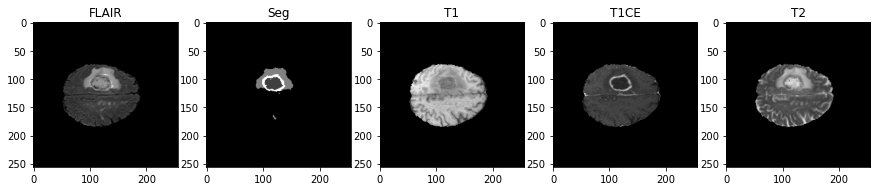

In [7]:
root = '../BRATS/brats2020_313subjects_noaugmentation_singlesegmentationchannel_min15percentcoverage'
channels =  ['FLAIR', 'Seg', 'T1', 'T1CE', 'T2']

channel_paths = [os.path.join(root, channel_dir) for channel_dir in channels]

FLAIR = [os.path.join(channel_paths[0], path) for path in sorted(os.listdir(channel_paths[0])) if path.endswith(".png")]
SEG = [os.path.join(channel_paths[1], path) for path in sorted(os.listdir(channel_paths[1])) if path.endswith(".png")]
T1 = [os.path.join(channel_paths[2], path) for path in sorted(os.listdir(channel_paths[2])) if path.endswith(".png")]
T1CE = [os.path.join(channel_paths[3], path) for path in sorted(os.listdir(channel_paths[3])) if path.endswith(".png")]
T2 = [os.path.join(channel_paths[4], path) for path in sorted(os.listdir(channel_paths[4])) if path.endswith(".png")]

ALL_CHANNELS = list(zip(FLAIR, SEG, T1, T1CE, T2))

example_idx = 1100
example_img = [io.imread(ALL_CHANNELS[example_idx][j]) for j in range(5)]
print(f"Shape: {example_img[0].shape}")

plt.figure(figsize=(15,5))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow(example_img[i], cmap="gray")
    plt.title(channels[i])
plt.show()

In [8]:
class Play_DS(Dataset):
    """DS to play around with behavior"""
    
    def __init__(self, img_paths):
        self.paths = img_paths
    
    def __len__(self):
        return len(self.paths) # Number of images

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        print(idx)

        return self.paths[idx]


In [9]:
Ex_DS = Play_DS(img_paths=["./img0", "./img1", "./img2", "./img3", "./img4", "./img5", "./img6"])
DL = DataLoader(Ex_DS, batch_size=2, shuffle=True)

for img in DL:
    print(img)

# We can see that it runs through the getitem for each index in the batch and then adds it so a tensor (here only 1-D, normally tensor with batch_size, img)
# If shuffle=True, get shuffled each run 
# If drop_last=True, last smaller batch will be dropped

5
1
['./img5', './img1']
2
3
['./img2', './img3']
0
6
['./img0', './img6']
4
['./img4']


In [10]:
tens_1 = torch.Tensor(example_img[0])
tens_1 = tens_1.unsqueeze(dim=0)

tens_2 = torch.Tensor(example_img[1])
tens_2 = tens_2.unsqueeze(dim=0)

# Concat two tensors
torch.cat([tens_1, tens_2], dim=0).shape

torch.Size([2, 256, 256])

In [11]:
from torch.utils.data import Dataset

class BRATS_sliced(Dataset):
    """Multichannel sliced BRATS dataset """

    def __init__(self, root_dir, channel_paths, transform=None):
        super().__init__()
        self.root_dir = root_dir
        self.channel_paths = channel_paths # List with lists of paths for each image-channel
        self.num_channel = len(channel_paths[0])
        self.transform = transform

    def __len__(self):
        return len(self.channel_paths)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        # Fetch all channels
        all_chan = [] # Store each channel tensor in list
        for c in range(self.num_channel):
            # Load image channel
            img_path = self.channel_paths[idx][c]
            img = io.imread(img_path)

            # Transform to tensor and unsqueeze in first dim
            img = torch.Tensor(img)
            img = img.unsqueeze(dim=0)
            all_chan.append(img)

        # Create and return tensor of size (Channels, Size, Size) 
        final_img = torch.cat(all_chan)

        #if self.transform:
        #    sample = self.transform(sample)

        return final_img
        

In [12]:
BRATS_DS = BRATS_sliced(root_dir="", channel_paths=ALL_CHANNELS[:32])
loader = DataLoader(BRATS_DS, batch_size=16, shuffle=True, drop_last=True)

In [13]:
for batch in loader: # Iterate over 
    print(batch.shape)

torch.Size([16, 5, 256, 256])
torch.Size([16, 5, 256, 256])


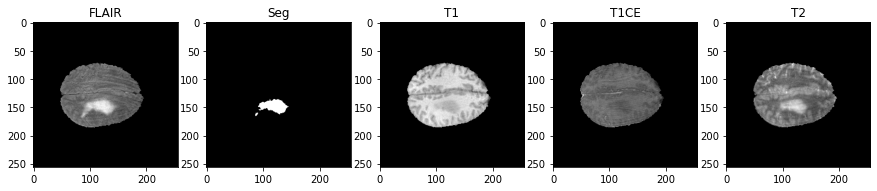

In [14]:
example_img = next(iter(loader))[0,:,:,:]
plt.figure(figsize=(15,5))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow(example_img[i,:,:], cmap="gray")
    plt.title(channels[i])
plt.show()

## Find cropping points

In [173]:
left = []
right = []
top = []
bottom = []

for file in T1CE:
    img = io.imread(file)
    # Columns
    bool_mask_col = np.apply_along_axis(lambda col: np.max(col)>0, 0, img)
    start_end_col = np.where(bool_mask_col)[0]
    if len(start_end_col)==0:
        continue
    crop_idx_left =  start_end_col[0] # Will return first occurence
    crop_idx_right =  start_end_col[-1] # Will return last occurence
    left.append(crop_idx_left)
    right.append(crop_idx_right)

    # Rows
    bool_mask_row = np.apply_along_axis(lambda row: np.max(row)>0, 1, img)
    start_end_row = np.where(bool_mask_row)[0]
    if len(start_end_row)==0:
        continue
    crop_idx_top =  start_end_row[0] # Will return first occurence
    crop_idx_bottom =  start_end_row[-1] # Will return last occurence
    top.append(crop_idx_top)
    bottom.append(crop_idx_bottom)

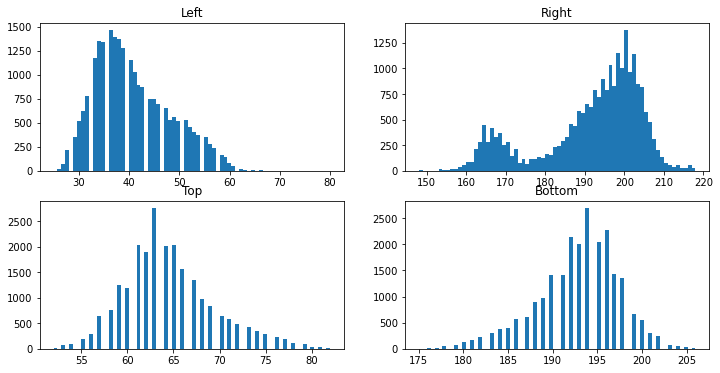

In [174]:
plt.figure(figsize=(12,6))
plt.subplot(2,2,1)
plt.hist(left, bins=70)
plt.title("Left")
plt.subplot(2,2,2)
plt.hist(right, bins=70)
plt.title("Right")
plt.subplot(2,2,3)
plt.hist(top, bins=70)
plt.title("Top")
plt.subplot(2,2,4)
plt.hist(bottom, bins=70)
plt.title("Bottom")
plt.show()

In [175]:
# Cols: 30:210
# Rows: 55:202
# Ending up with 210-30=180 so 180x180 then downsample to 128x128?

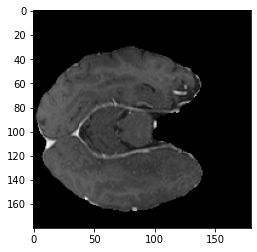

In [180]:
# Example
img = io.imread(T1CE[400])
cropped = img[30:210, 30:210]
plt.imshow(cropped, cmap="gray")
plt.show()

In [181]:
# Does the loader in BRATS stop if one whole epoch?
BRATS_DS = BRATS_sliced(root_dir="", channel_paths=ALL_CHANNELS[:4])
loader = DataLoader(BRATS_DS, batch_size=2, shuffle=True, drop_last=True)

def tryit(loader):
    yield from loader

In [182]:
hello = tryit(loader)

In [183]:
while True:
    a = next(hello)

StopIteration: 

## How does yield for DataLoader work? 

In [185]:
torch.__version__

'1.10.0'

In [68]:
from torch.utils.data import DataLoader, Dataset
class MyDataset(Dataset):
    def __init__(self):
        self.bob = [0,1,2,10,11,12, 21,22,23,24]
    def __len__(self):
        return len(self.bob)
    def __getitem__(self, idx):
        print(f'idx = {idx}')
        return self.bob[idx]

dataset = DataLoader(MyDataset(), batch_size = 2, shuffle = True, num_workers = 0)

In [69]:
def get(loader):
    while True:
        yield from loader

genn = get(dataset)

In [72]:
count_dict = {}
for i in range(10):
    els = next(genn)
    el_1 = int(els[0])
    print(els)
    if el_1 in count_dict:
        count_dict[el_1] += 1
    else:
        count_dict[el_1] = 1

idx = 5
idx = 4
tensor([12, 11])
idx = 6
idx = 8
tensor([21, 23])
idx = 9
idx = 0
tensor([24,  0])
idx = 3
idx = 7
tensor([10, 22])
idx = 1
idx = 2
tensor([1, 2])
idx = 0
idx = 6
tensor([ 0, 21])
idx = 2
idx = 5
tensor([ 2, 12])
idx = 9
idx = 3
tensor([24, 10])
idx = 1
idx = 4
tensor([ 1, 11])
idx = 8
idx = 7
tensor([23, 22])


In [65]:
count_dict

{0: 4, 2: 4, 11: 4, 21: 4, 23: 4}

### Important takeaways:
- If shuffle is False, the objects are yielded in order, so not random every time!
- If shuffle is True, they are yielded randomly but still epoch after epoch! So if with 10 items and batch size 2 5 iterations are over, the new epoch starts and it is guarantueed, that in the first epoch all items were loeaded exactly ONCE

BTW:
prefetch_factor (int, optional, keyword-only arg) – Number of batches loaded in advance by each worker. 2 means there will be a total of 2 * num_workers batches prefetched across all workers. (default: 2)